In [1]:
import os
import re
import torch
from transformers import T5EncoderModel, AutoTokenizer
from pathlib import Path
from f5_tts.infer.utils_infer import (
    infer_process,
    load_vocoder,
    preprocess_ref_audio_text,
    remove_silence_for_generated_wav,
)
from f5_tts.model.cfm import T5Conditioner
from f5_tts.model import DiTPrepend, CFM
from f5_tts.model.utils import get_tokenizer
from f5_tts.train.utils import make_html
import torchaudio
import argparse
import requests

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if torch.cuda.is_available():
    torch.set_float32_matmul_precision("high")

cfg_strength = 2.0
scale_phi = 0.75

mel_spec_type = "vocos"
vocoder_name = mel_spec_type
target_sample_rate = 24000
n_mel_channels = 100
hop_length = 256
win_length = 1024
n_fft = 1024
target_rms = 0.1
cross_fade_duration = 0.15
ode_method = "euler"
nfe_step = 32  # 16, 32
sway_sampling_coef = -1.0
speed = 1.0
fix_duration = None
vocab_file = "./f5_tts/infer/examples/vocab.txt"
tokenizer = "custom"
ode_method = "euler"

# load model
model_cls = DiTPrepend
model_cfg = dict(
    dim=1024, 
    depth=22, 
    heads=16, 
    ff_mult=2, 
    text_dim=512, 
    conv_layers=4
)

In [5]:
vocab_char_map, vocab_size = get_tokenizer(vocab_file, tokenizer)
if vocoder_name == "bigvgan":
    vocoder = load_vocoder(vocoder_name=vocoder_name, is_local=False)
else:
    vocoder = load_vocoder(vocoder_name=vocoder_name, is_local=True, local_path=f"./f5_tts/vocoder")

print("Load 1")
transformer=model_cls(**model_cfg, text_num_embeds=vocab_size, mel_dim=n_mel_channels)
text_conditioner = T5Conditioner(t5_model_name="t5-base", max_length=32).to(device)
text_conditioner.eval()

mel_spec_kwargs=dict(
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    n_mel_channels=n_mel_channels,
    target_sample_rate=target_sample_rate,
    mel_spec_type=mel_spec_type,
)

odeint_kwargs=dict(
    method=ode_method,
)

print("Load 2")
model = CFM(
    transformer=transformer,
    mel_spec_kwargs=mel_spec_kwargs,
    odeint_kwargs=odeint_kwargs,
    vocab_char_map=vocab_char_map,
).to(device)

dtype = torch.float32

print("Load 3")

ckpt_path = "/workspace/f5tts_clone_qwen_filter_7.pt"
checkpoint = torch.load(ckpt_path, map_location=device, weights_only=True)
model.load_state_dict(checkpoint)
# print(checkpoint)
del checkpoint
torch.cuda.empty_cache()

Load vocos from local path ./f5_tts/vocoder
Load 1
Load 2
Load 3


In [14]:
import time

st = time.time()
# generate #
t_inter = 0.1
duplicate_test = False

script = "Come here!"

main_voice = {"ref_audio": "./zombie-or-monster-says-i-sound-effect-079567563_nw_prev.mp3", "ref_text": "I hate you so much."}
voices = {"main": main_voice}
for voice in voices:
    voices[voice]["ref_audio"], voices[voice]["ref_text"] = preprocess_ref_audio_text(
        voices[voice]["ref_audio"], voices[voice]["ref_text"]
    )

audio, final_sample_rate, spectragram = infer_process(
    voices[voice]["ref_audio"],
    voices[voice]["ref_text"],
    script, 
    model, 
    vocoder, 
    mel_spec_type=mel_spec_type, 
    speed=speed,
    cfg_strength=cfg_strength,
    no_ref_audio=False,
    scale_phi=scale_phi,
    t_inter=t_inter,
    duplicate_test=duplicate_test,
    batch_size=1
)

print("Adua ", time.time() - st)
if vocoder_name == "bigvgan":
    array = torch.stack((torch.tensor(audio), torch.tensor(audio)), dim=0).squeeze()
else:
    array = torch.stack((torch.tensor(audio).unsqueeze(dim=1), torch.tensor(audio).unsqueeze(dim=1)), dim=1).squeeze()

array = array.to(dtype).cpu().detach().numpy()


Converting audio...
Using custom reference text...
gen_text 0 Come here!
Generating audio in 1 batches...


  0%|          | 0/1 [00:00<?, ?it/s]

before start :  torch.Size([1, 69910]) [['I', ' ', 'h', 'a', 't', 'e', ' ', 'y', 'o', 'u', ' ', 's', 'o', ' ', 'm', 'u', 'c', 'h', '.', ' ', ' ', 'C', 'o', 'm', 'e', ' ', 'h', 'e', 'r', 'e', '!']] 403 32 False False 1


100%|██████████| 1/1 [00:01<00:00,  1.44s/it]

Adua  1.6449377536773682


/usr/local/lib/python3.11/dist-packages/audiotools/core/audio_signal.py:601: UserWarning: Audio amplitude > 1 clipped when saving
  warnings.warn("Audio amplitude > 1 clipped when saving")



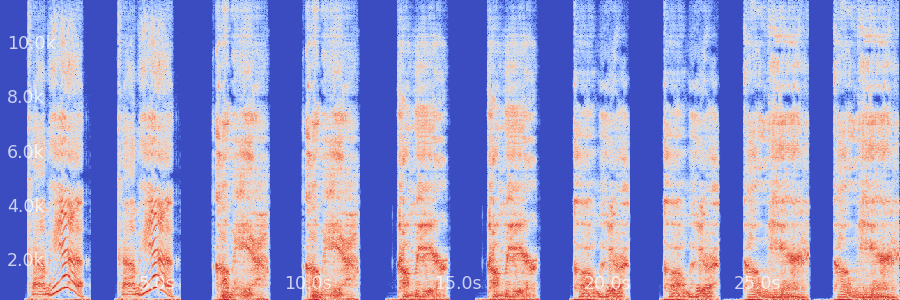
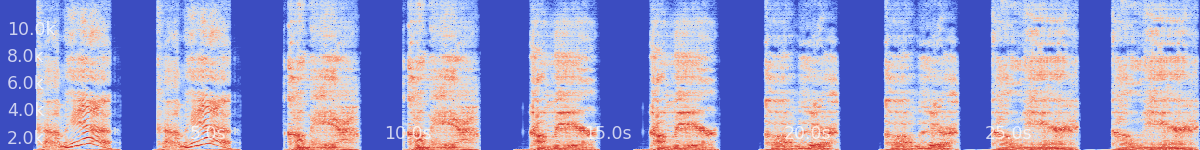